# Single member analyses of models with future scenarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath = '../Processed_data/Nino3_4_DJF/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict = {}
for model in models:
    data_dict[model] = {}
    
    file = datapath + model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(file, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list = data_table[exp][member].values
                data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])         
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])  
# We know from testing in Figure 1 that all time series for these members are long enough (no missing years)

## Choose a model

In [3]:
model = models[-1]
model

'MCM-UA-1-0'

ssp245
ssp370
ssp585


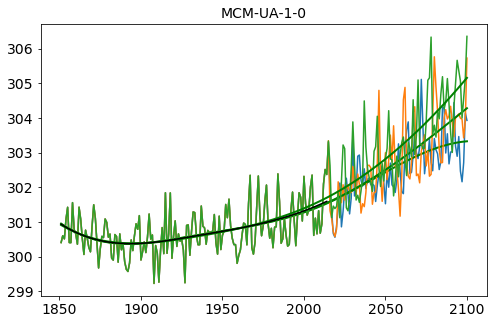

In [6]:
fig, ax = plt.subplots(figsize = [8,5])

internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1851, 2015) # no DJF mean in 1850
ssp_years = np.arange(2015, 2101)
all_years = np.arange(1851, 2101)
ssp_length = 86; # cut in year 2100. Some exp go beyond this year.

hist_data = data_dict[model]['historical']
hist_trends = {}

# combine historical and ssp data, then smooth the combined time series
# to minimize discontinuity of the trend between years 2014 - 2015
for exp in data_dict[model].keys():
    if exp not in ['piControl', 'historical']:
        print(exp)
        exp_data = np.concatenate((hist_data, data_dict[model][exp][:ssp_length]))
        plt.plot(all_years, exp_data) 
        spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
        hist_trends[exp] = spl(hist_years)
        ax.plot(all_years, spl(all_years), 'g', lw=2)
    
# define historical trend as the mean trend over the historical period
hist_trends_mean = np.zeros_like(hist_years, dtype=float)
for t in range(len(hist_years)):
    hist_trends_mean[t] = np.mean([hist_trends[exp][t] for exp in hist_trends.keys()])

ax.plot(hist_years, hist_trends_mean, color = 'black');
ax.set_title(model, fontsize = 14)
ax.tick_params(axis='both',labelsize=14)   
#ax.set_xlim(1850, 2015)
#ax.set_ylim(299, 301)

## Loop through all models and create dictionary of anomaly data:

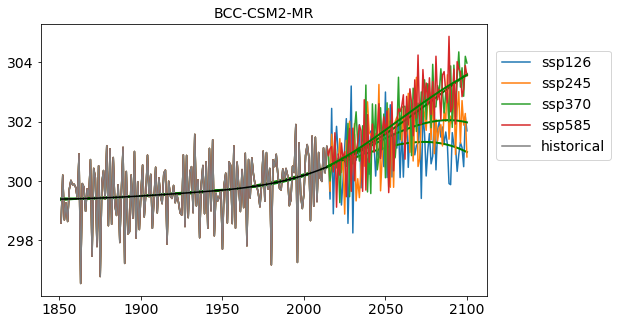

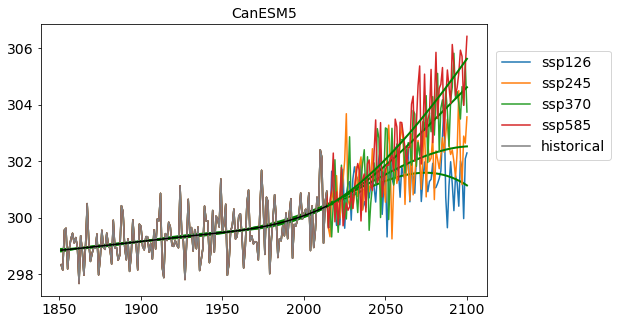

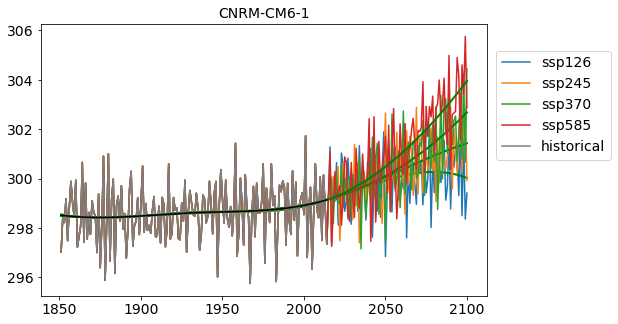

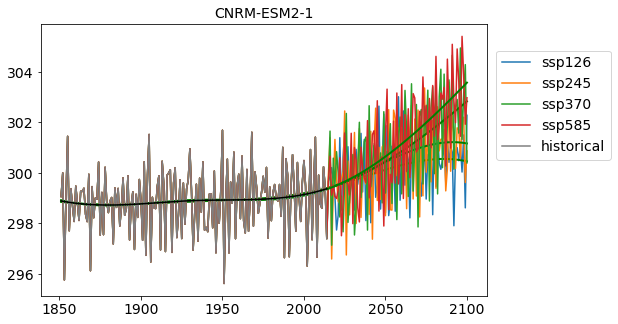

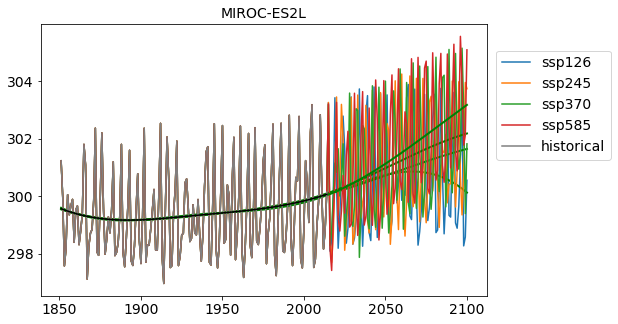

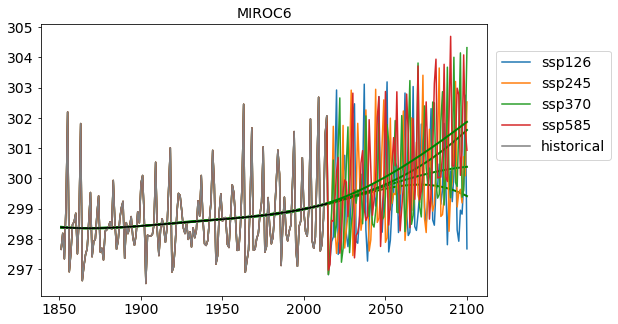

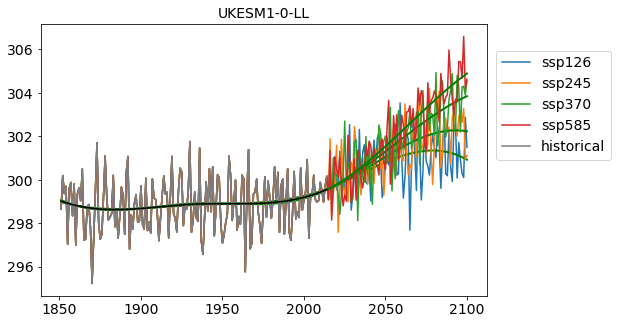

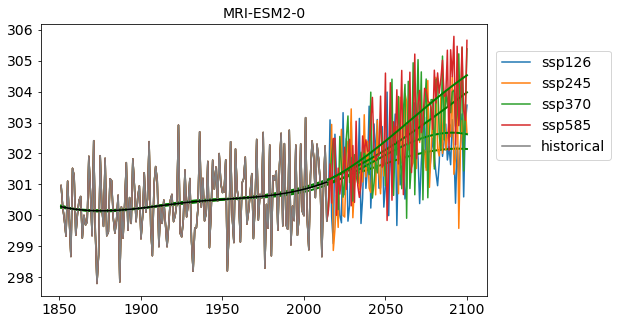

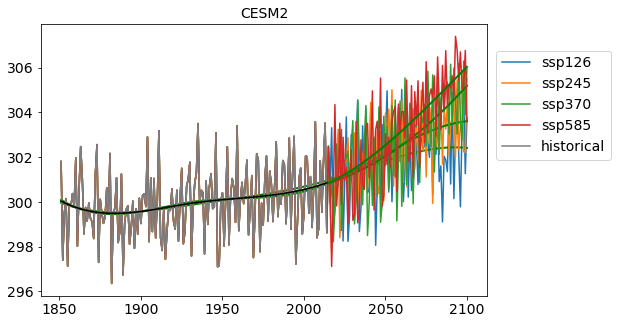

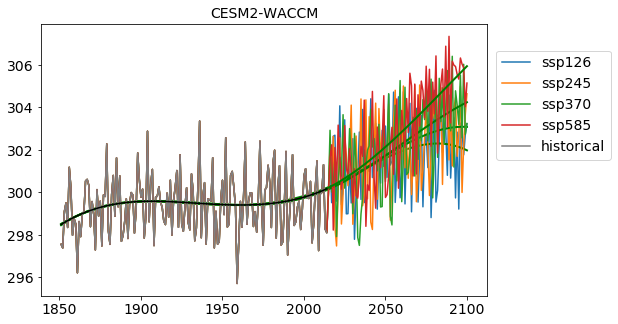

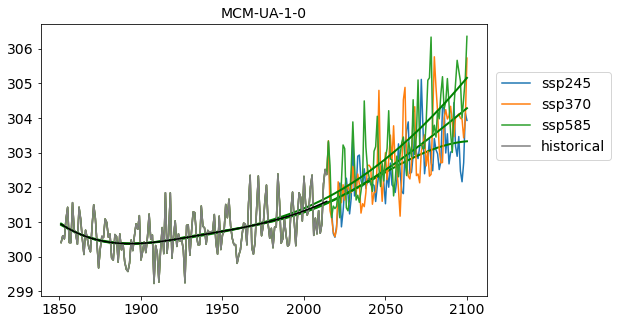

In [23]:
internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1851, 2015) # no DJF mean in 1850
ssp_years = np.arange(2015, 2101)
all_years = np.arange(1851, 2101)
ssp_length = 86; # cut in year 2100. Some exp go beyond this year.

anomalies = {}

for model in models:
    anomalies[model] = {}
    fig, ax = plt.subplots(figsize = [8,5])

    hist_data = data_dict[model]['historical']
    hist_trends = {}

    # combine historical and ssp data, then smooth the combined time series
    # to minimize discontinuity of the trend between years 2014 - 2015
    for exp in data_dict[model].keys():
        if exp not in ['piControl', 'historical']:
            exp_data = np.concatenate((hist_data, data_dict[model][exp][:ssp_length]))
            plt.plot(all_years, exp_data, label = exp) 
            spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
            hist_trends[exp] = spl(hist_years)
            ax.plot(all_years, spl(all_years), 'g', lw=2)
            
            # save ssp anomaly in dictionary
            anomalies[model][exp] = data_dict[model][exp][:ssp_length] - spl(ssp_years)

    # define historical trend as the mean trend over the historical period
    hist_trends_mean = np.zeros_like(hist_years, dtype=float)
    for t in range(len(hist_years)):
        hist_trends_mean[t] = np.mean([hist_trends[exp][t] for exp in hist_trends.keys()])
        
    # save historical anomaly in dictionary
    anomalies[model]['historical'] = hist_data - hist_trends_mean
    
    ax.plot(hist_years, hist_data, color = 'gray', label = 'historical')
    ax.plot(hist_years, hist_trends_mean, color = 'black');
    ax.set_title(model, fontsize = 14)
    ax.tick_params(axis='both',labelsize=14)
    ax.legend(loc=(1.02,0.5), fontsize = 14);
    

## Study anomalies:

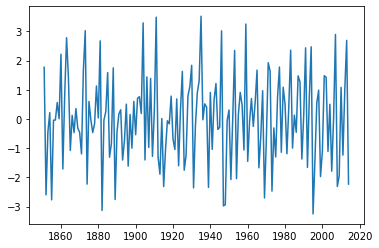

In [24]:
plt.plot(hist_years, anomalies['CESM2']['historical']);